## Importieren Bibliotheken

In [ ]:
import numpy
import pandas
import tensorflow
import matplotlib

## Hochladen von Dateien 

In [ ]:
from google.colab import files
uploaded = files.upload()


Saving label_encoded_table.csv to label_encoded_table (1).csv


## Laden und Standardisieren numerischer Daten mit Dask unter Berücksichtigung spezifischer Datentypen


In [ ]:
import dask.dataframe as dd

data_path = 'label_encoded_table.csv'

# Specify dtypes for problematic columns during data loading
dtype={'contract_number': 'object', 'sub_obj': 'object'}

# Load data using Dask with specified dtypes
data = dd.read_csv(data_path, dtype=dtype)  # Pass dtype argument here

# Select only numeric columns for standardization
numeric_cols = data.select_dtypes(include=['number']).columns
data_numeric = data[numeric_cols]

# Standardize the numeric data
data_numeric = data_numeric.map_partitions(lambda df: (df - df.mean()) / df.std(), meta=data_numeric)

# Reassign standardized numeric columns to original dataframe
# Instead of: data[numeric_cols] = data_numeric
# Ensure only numeric columns are included when assigning
for col in numeric_cols:  # Iterate through numeric columns
    # Check if column is numeric before assigning
    if data[col].dtype != object:  # Exclude object (string) columns
        data = data.assign(**{col: data_numeric[col]}) # Assign each column individually using assign

# Convert only numeric columns to float32
# Instead of converting the entire DataFrame to float32
# Use .assign to update columns individually within a loop
for col in numeric_cols:
    if data[col].dtype != object: # Ensure column is numeric
        data = data.assign(**{col: data[col].astype('float32')}) # Assign and cast to float32

# Compute the result
data = data.compute()


/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


## Erstellung eines Generators mit TensorFlow/Keras

In [ ]:
import tensorflow as tf

def build_generator(input_dim, output_dim, hidden_units=128):
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(hidden_units, activation='relu', input_dim=input_dim),
        tf.keras.layers.Dense(hidden_units, activation='relu'),
        tf.keras.layers.Dense(output_dim, activation='tanh')
    ])
    return model

## Erstellung eines Diskriminators mit TensorFlow/Keras

In [ ]:
def build_discriminator(input_dim, hidden_units=128):
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(hidden_units, activation='relu', input_dim=input_dim),
        tf.keras.layers.Dense(hidden_units, activation='relu'),
        tf.keras.layers.Dense(1)  # No activation for Wasserstein loss
    ])
    return model


## Definition des Wasserstein-Verlusts für GANs

In [ ]:
def wasserstein_loss(y_true, y_pred):
    return tf.reduce_mean(y_true * y_pred)


## Berechnung der Gradientenstrafe (Gradient Penalty) für stabileres Training in Wasserstein-GANs

In [ ]:
def gradient_penalty(discriminator, real_data, fake_data):
    alpha = tf.random.uniform([real_data.shape[0], 1])
    interpolated = alpha * real_data + (1 - alpha) * fake_data
    with tf.GradientTape() as tape:
        tape.watch(interpolated)
        pred = discriminator(interpolated)
    grads = tape.gradient(pred, interpolated)
    grad_norm = tf.sqrt(tf.reduce_sum(tf.square(grads), axis=1))
    return tf.reduce_mean((grad_norm - 1.0) ** 2)


##  Definition der Optimierer für Generator und Diskriminator in einem Wasserstein-GAN

In [ ]:
generator_optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4, beta_1=0.5, beta_2=0.9)
discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate=1e-5, beta_1=0.5, beta_2=0.9)

## Implementierung einer WGAN-Klasse mit Gradient Penalty und Trainingslogik

In [ ]:
class WGAN:
    def __init__(self, input_dim, data_dim, generator_lr=0.0002, discriminator_lr=0.0002, gp_weight=10, n_critic=5):
        self.input_dim = input_dim
        self.data_dim = data_dim
        self.gp_weight = gp_weight
        self.n_critic = n_critic

        # Build models
        self.generator = build_generator(input_dim, data_dim)
        self.discriminator = build_discriminator(data_dim)

        # Optimizers
        self.generator_optimizer = tf.keras.optimizers.Adam(generator_lr, beta_1=0.5, beta_2=0.9)
        self.discriminator_optimizer = tf.keras.optimizers.Adam(discriminator_lr, beta_1=0.5, beta_2=0.9)

    def train_step(self, real_data):
        batch_size = tf.shape(real_data)[0]
        random_latent_vectors = tf.random.normal([batch_size, self.input_dim])

        for _ in range(self.n_critic):
            with tf.GradientTape() as tape:
                # Generate fake data
                fake_data = self.generator(random_latent_vectors, training=True)
                real_validity = self.discriminator(real_data, training=True)
                fake_validity = self.discriminator(fake_data, training=True)
                gp = gradient_penalty(self.discriminator, real_data, fake_data)
                d_loss = tf.reduce_mean(fake_validity) - tf.reduce_mean(real_validity) + self.gp_weight * gp
            gradients = tape.gradient(d_loss, self.discriminator.trainable_variables)
            self.discriminator_optimizer.apply_gradients(zip(gradients, self.discriminator.trainable_variables))

        with tf.GradientTape() as tape:
            fake_data = self.generator(random_latent_vectors, training=True)
            fake_validity = self.discriminator(fake_data, training=True)
            g_loss = -tf.reduce_mean(fake_validity)
        gradients = tape.gradient(g_loss, self.generator.trainable_variables)
        self.generator_optimizer.apply_gradients(zip(gradients, self.generator.trainable_variables))

        return d_loss, g_loss

    def generate(self, num_samples):
        random_latent_vectors = tf.random.normal([num_samples, self.input_dim])
        return self.generator(random_latent_vectors).numpy()


## Training eines Wasserstein-GANs (WGAN) und Generierung synthetischer Daten


In [ ]:

import numpy as np

# Example dataset: Random Gaussian data
real_data = np.random.normal(0, 1, (1000, 2)).astype('float32')

# Initialize WGAN
wgan = WGAN(input_dim=10, data_dim=2)

# Training
epochs = 500
batch_size = 32
for epoch in range(epochs):
    idx = np.random.randint(0, real_data.shape[0], batch_size)
    real_batch = real_data[idx]
    d_loss, g_loss = wgan.train_step(real_batch)
    if epoch % 500 == 0:
        print(f"Epoch {epoch}, Discriminator Loss: {d_loss.numpy()}, Generator Loss: {g_loss.numpy()}")

# Generate synthetic data
synthetic_data = wgan.generate(100000)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 0, Discriminator Loss: 8.145421981811523, Generator Loss: 0.015044307336211205


##  Visualisierung von echten und synthetischen Daten mit Matplotlib

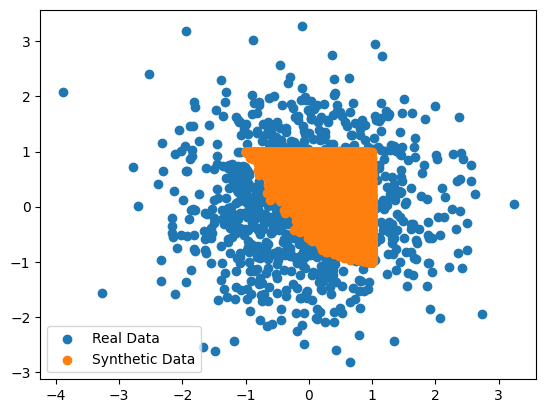

In [ ]:
import matplotlib.pyplot as plt # Import the necessary module and alias it as plt

# Visualize real vs synthetic data
plt.scatter(real_data[:, 0], real_data[:, 1], label="Real Data")
plt.scatter(synthetic_data[:, 0], synthetic_data[:, 1], label="Synthetic Data")
plt.legend()
plt.show()

## Dichtevergleich von echten und synthetischen Daten mit Seaborn

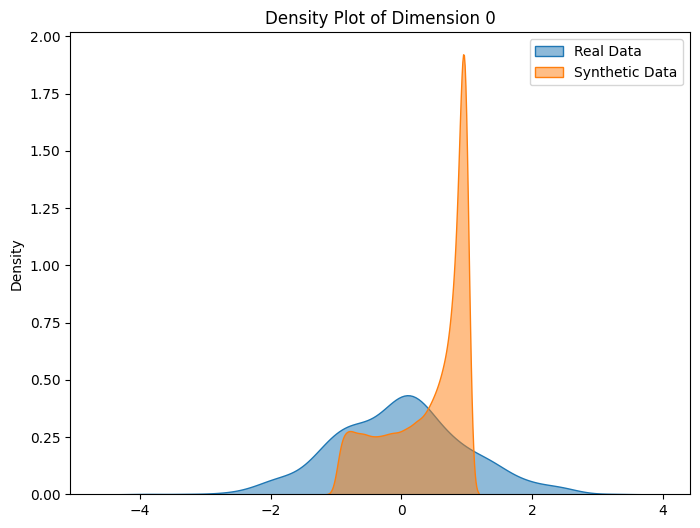

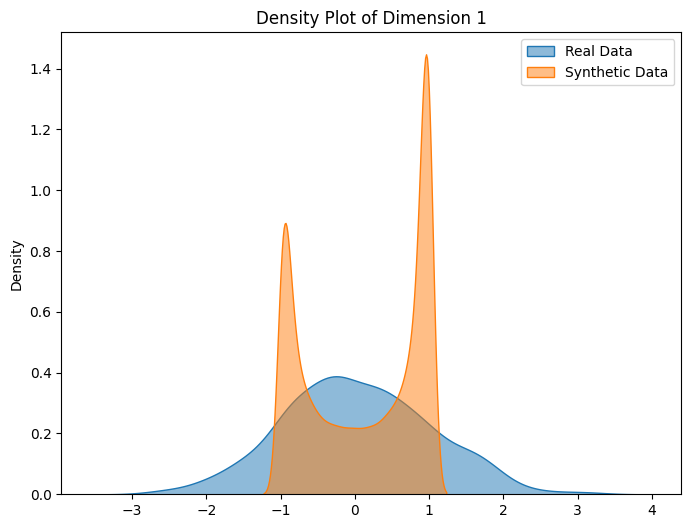

In [ ]:
import seaborn as sns

def plot_density(real_data, synthetic_data, dim=0):
    plt.figure(figsize=(8, 6))
    sns.kdeplot(real_data[:, dim], label='Real Data', fill=True, alpha=0.5)
    sns.kdeplot(synthetic_data[:, dim], label='Synthetic Data', fill=True, alpha=0.5)
    plt.title(f'Density Plot of Dimension {dim}')
    plt.legend()
    plt.show()

plot_density(real_data, synthetic_data, dim=0)  # Plot for the first dimension
plot_density(real_data, synthetic_data, dim=1)  # Plot for the second dimension

## Random forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
import numpy as np

# Combine real and synthetic data
real_labels = np.zeros(real_data.shape[0])  # Label for real data
synthetic_labels = np.ones(synthetic_data.shape[0])  # Label for synthetic data

# Combine the data and labels
data = np.vstack((real_data, synthetic_data))
labels = np.hstack((real_labels, synthetic_labels))

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.3, random_state=42)

# Train Random Forest Classifier
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Predict and evaluate
y_pred = rf_model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))


Accuracy: 0.9965016501650165

Classification Report:
               precision    recall  f1-score   support

         0.0       0.98      0.67      0.80       311
         1.0       1.00      1.00      1.00     29989

    accuracy                           1.00     30300
   macro avg       0.99      0.84      0.90     30300
weighted avg       1.00      1.00      1.00     30300



## Decission Tree

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score
import numpy as np

# Combine real and synthetic data
real_labels = np.zeros(real_data.shape[0])  # Label for real data
synthetic_labels = np.ones(synthetic_data.shape[0])  # Label for synthetic data

# Combine the data and labels
data = np.vstack((real_data, synthetic_data))
labels = np.hstack((real_labels, synthetic_labels))

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.3, random_state=42)

# Train Decision Tree Classifier
dt_model = DecisionTreeClassifier(random_state=42)
dt_model.fit(X_train, y_train)

# Predict on the test set
y_pred = dt_model.predict(X_test)

# Compute Metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# Print Metrics
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")

# Detailed Classification Report
print("\nClassification Report:\n", classification_report(y_test, y_pred, target_names=["Real", "Synthetic"]))


Accuracy: 0.99
Precision: 1.00
Recall: 1.00
F1 Score: 1.00

Classification Report:
               precision    recall  f1-score   support

        Real       0.74      0.67      0.71       311
   Synthetic       1.00      1.00      1.00     29989

    accuracy                           0.99     30300
   macro avg       0.87      0.83      0.85     30300
weighted avg       0.99      0.99      0.99     30300



## Isolation Forest

In [ ]:
from sklearn.ensemble import IsolationForest
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
import numpy as np

# Combine real and synthetic data
real_labels = np.zeros(real_data.shape[0])  # Label for real data (normal)
synthetic_labels = np.ones(synthetic_data.shape[0])  # Label for synthetic data (anomalies)

# Combine data and labels
data = np.vstack((real_data, synthetic_data))
labels = np.hstack((real_labels, synthetic_labels))

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.3, random_state=42)

# Train Isolation Forest
iso_forest = IsolationForest(n_estimators=100, contamination="auto", random_state=42)
iso_forest.fit(X_train)

# Predict on the test set
# Isolation Forest predicts -1 for anomalies and 1 for normal points
y_pred_raw = iso_forest.predict(X_test)
y_pred = np.where(y_pred_raw == 1, 0, 1)  # Convert to 0 (normal) and 1 (anomaly)

# Compute Metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# Print Metrics
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")

# Detailed Classification Report
print("\nClassification Report:\n", classification_report(y_test, y_pred, target_names=["Normal", "Anomaly"]))


Accuracy: 0.34
Precision: 0.97
Recall: 0.34
F1 Score: 0.51

Classification Report:
               precision    recall  f1-score   support

      Normal       0.00      0.11      0.00       311
     Anomaly       0.97      0.34      0.51     29989

    accuracy                           0.34     30300
   macro avg       0.49      0.23      0.26     30300
weighted avg       0.96      0.34      0.50     30300



## XGBoost

In [ ]:
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score
import numpy as np

# Combine real and synthetic data
real_labels = np.zeros(real_data.shape[0])  # Label for real data
synthetic_labels = np.ones(synthetic_data.shape[0])  # Label for synthetic data

# Combine the data and labels
data = np.vstack((real_data, synthetic_data))
labels = np.hstack((real_labels, synthetic_labels))

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.3, random_state=42)

# Train XGBoost Classifier
xgb_model = XGBClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=6,
    use_label_encoder=False,  # Avoid warning for label encoding in new versions of XGBoost
    eval_metric='logloss',   # Specify evaluation metric
    random_state=42
)
xgb_model.fit(X_train, y_train)

# Predict on the test set
y_pred = xgb_model.predict(X_test)

# Compute Metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# Print Metrics
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")

# Detailed Classification Report
print("\nClassification Report:\n", classification_report(y_test, y_pred, target_names=["Real", "Synthetic"]))


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [08:29:01] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Accuracy: 1.00
Precision: 1.00
Recall: 1.00
F1 Score: 1.00

Classification Report:
               precision    recall  f1-score   support

        Real       0.94      0.61      0.74       311
   Synthetic       1.00      1.00      1.00     29989

    accuracy                           1.00     30300
   macro avg       0.97      0.81      0.87     30300
weighted avg       1.00      1.00      1.00     30300



## LightGBM

In [ ]:
pip install lightgbm --upgrade


In [ ]:
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score
import numpy as np

# Combine real and synthetic data
real_labels = np.zeros(real_data.shape[0])  # Label for real data
synthetic_labels = np.ones(synthetic_data.shape[0])  # Label for synthetic data

# Combine the data and labels
data = np.vstack((real_data, synthetic_data))
labels = np.hstack((real_labels, synthetic_labels))

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.3, random_state=42)

# Convert data into LightGBM dataset format
train_data = lgb.Dataset(X_train, label=y_train)
test_data = lgb.Dataset(X_test, label=y_test)

# Define LightGBM parameters
params = {
    'objective': 'binary',        # Binary classification
    'metric': 'binary_logloss',   # Evaluation metric
    'boosting_type': 'gbdt',      # Gradient Boosting Decision Tree
    'num_leaves': 31,             # Maximum number of leaves in one tree
    'learning_rate': 0.1,         # Step size shrinkage
    'feature_fraction': 0.9       # Randomly select a subset of features
}

# Use a callback for early stopping
callbacks = [lgb.early_stopping(stopping_rounds=10)]

# Train the LightGBM model
lgb_model = lgb.train(
    params,
    train_data,
    num_boost_round=100,
    valid_sets=[train_data, test_data],  # Provide both training and testing data for validation
    callbacks=callbacks                  # Use the early stopping callback
)

# Predict on the test set
y_pred_proba = lgb_model.predict(X_test)  # Probabilities
y_pred = (y_pred_proba > 0.5).astype(int)  # Convert probabilities to binary predictions

# Compute Metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# Print Metrics
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")

# Detailed Classification Report
print("\nClassification Report:\n", classification_report(y_test, y_pred, target_names=["Real", "Synthetic"]))


[LightGBM] [Info] Number of positive: 70011, number of negative: 689
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.038620 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 70700, number of used features: 2
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.990255 -> initscore=4.621166
[LightGBM] [Info] Start training from score 4.621166
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[36]	training's binary_logloss: 0.0137343	valid_1's binary_logloss: 0.0216729
Accuracy: 1.00
Precision: 1.00
Recall: 1.00
F1 Score: 1.00

Classification Report:
               precision    recall  f1-score   support

        Real       0.95      0.61      0.75       311
   Synthetic       1.00      1.00      1.00     29989

    accuracy                           1.00     30300
   macro avg       0.98      0.81   

## BARCHART Matrix

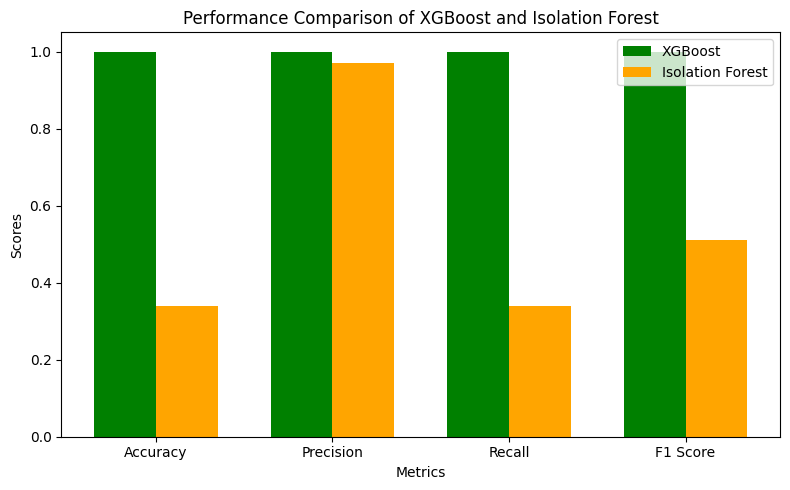

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Metrics for XGBoost and Isolation Forest
metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
xgboost_scores = [1.00, 1.00, 1.00, 1.00]  # XGBoost results
isolation_forest_scores = [0.34, 0.97, 0.34, 0.51]  # Isolation Forest results

# Create a bar chart
x = np.arange(len(metrics))
width = 0.35

fig, ax = plt.subplots(figsize=(8, 5))
ax.bar(x - width / 2, xgboost_scores, width, label='XGBoost', color='green')
ax.bar(x + width / 2, isolation_forest_scores, width, label='Isolation Forest', color='orange')

# Add labels and legend
ax.set_xlabel('Metrics')
ax.set_ylabel('Scores')
ax.set_title('Performance Comparison of XGBoost and Isolation Forest')
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.legend()

plt.tight_layout()
plt.show()


## Decission boundry

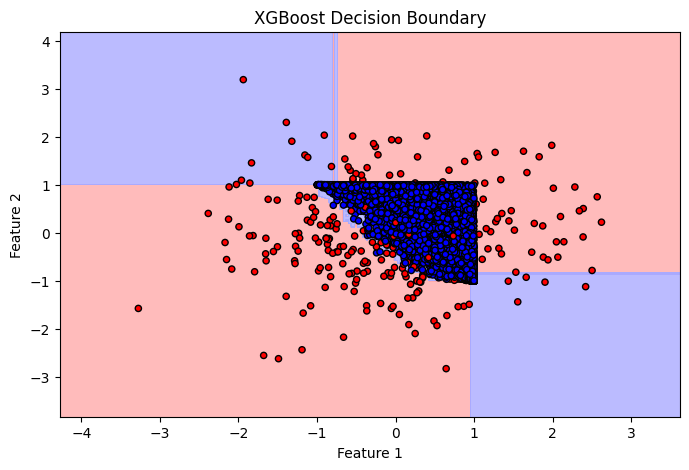

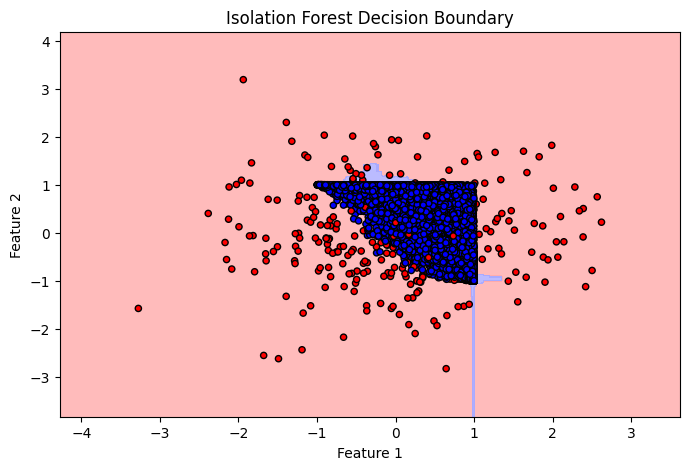

In [ ]:
from matplotlib.colors import ListedColormap
import numpy as np

def plot_decision_boundary(model, X, y, title):
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01),
                         np.arange(y_min, y_max, 0.01))
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.figure(figsize=(8, 5))
    plt.contourf(xx, yy, Z, alpha=0.8, cmap=ListedColormap(['#FFAAAA', '#AAAAFF']))
    plt.scatter(X[:, 0], X[:, 1], c=y, edgecolor='k', s=20, cmap=ListedColormap(['#FF0000', '#0000FF']))
    plt.title(title)
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.show()

# Decision Boundary for XGBoost
plot_decision_boundary(xgb_model, X_test, y_test, "XGBoost Decision Boundary")

# Decision Boundary for Isolation Forest
plot_decision_boundary(iso_forest, X_test, y_test, "Isolation Forest Decision Boundary")


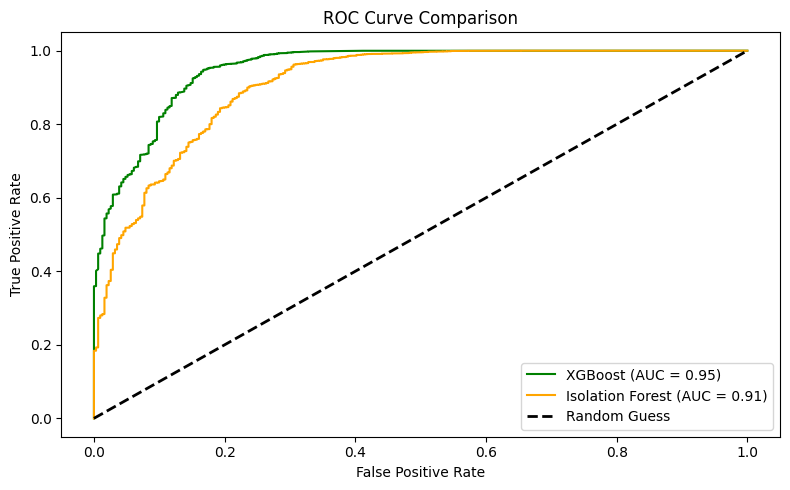

In [ ]:
from sklearn.metrics import roc_curve, auc

# Compute ROC Curve for XGBoost
xgboost_proba = xgb_model.predict_proba(X_test)[:, 1]
fpr_xg, tpr_xg, _ = roc_curve(y_test, xgboost_proba)
roc_auc_xg = auc(fpr_xg, tpr_xg)

# Compute ROC Curve for Isolation Forest
iso_forest_proba = iso_forest.decision_function(X_test)
fpr_iso, tpr_iso, _ = roc_curve(y_test, iso_forest_proba)
roc_auc_iso = auc(fpr_iso, tpr_iso)

# Plot ROC Curves
plt.figure(figsize=(8, 5))
plt.plot(fpr_xg, tpr_xg, label=f'XGBoost (AUC = {roc_auc_xg:.2f})', color='green')
plt.plot(fpr_iso, tpr_iso, label=f'Isolation Forest (AUC = {roc_auc_iso:.2f})', color='orange')
plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend()
plt.tight_layout()
plt.show()


## Pressicion Recall

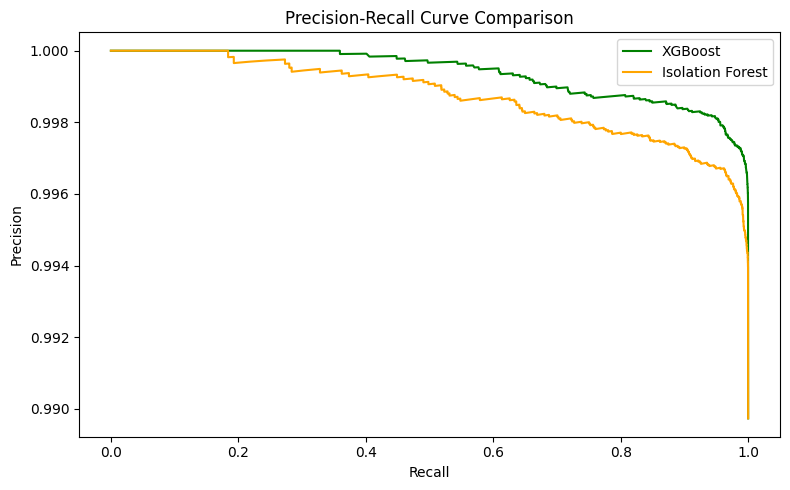

In [ ]:
from sklearn.metrics import precision_recall_curve

# Compute Precision-Recall Curve for XGBoost
precision_xg, recall_xg, _ = precision_recall_curve(y_test, xgboost_proba)

# Compute Precision-Recall Curve for Isolation Forest
precision_iso, recall_iso, _ = precision_recall_curve(y_test, iso_forest_proba)

# Plot Precision-Recall Curves
plt.figure(figsize=(8, 5))
plt.plot(recall_xg, precision_xg, label='XGBoost', color='green')
plt.plot(recall_iso, precision_iso, label='Isolation Forest', color='orange')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve Comparison')
plt.legend()
plt.tight_layout()
plt.show()


## Confusion Matrix

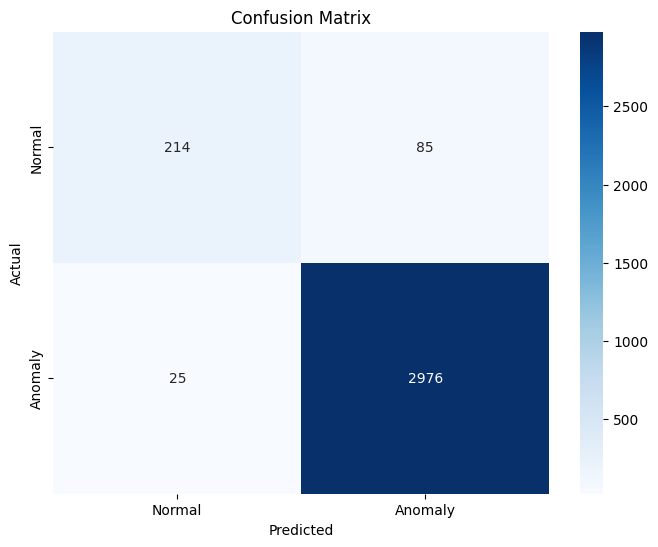

In [ ]:
# Import necessary libraries
import matplotlib.pyplot as plt
import seaborn as sns  # Import seaborn for heatmap
from sklearn.metrics import confusion_matrix # Import confusion_matrix


# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Normal", "Anomaly"], yticklabels=["Normal", "Anomaly"])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

## Implementierung des Baseline-Modells 4: Hinzufügen lokaler und globaler Anomalien

In [ ]:
import numpy as np

def add_global_anomalies(data, num_anomalies, deviation_factor=10):
    """
    Add global anomalies to the dataset.
    Parameters:
        data (numpy array): Original dataset.
        num_anomalies (int): Number of anomalies to add.
        deviation_factor (float): Factor to deviate anomalies from the mean.
    Returns:
        data_with_anomalies (numpy array): Dataset with anomalies.
    """
    mean = np.mean(data, axis=0)
    std = np.std(data, axis=0)
    anomalies = mean + deviation_factor * std * np.random.normal(size=(num_anomalies, data.shape[1]))
    return np.vstack((data, anomalies)), np.hstack((np.zeros(data.shape[0]), np.ones(num_anomalies)))  # Label anomalies as 1


def add_local_anomalies(data, num_anomalies, cluster_center=None, deviation_factor=0.5):
    """
    Add local anomalies to the dataset.
    Parameters:
        data (numpy array): Original dataset.
        num_anomalies (int): Number of anomalies to add.
        cluster_center (numpy array): Center point of the cluster for local anomalies.
        deviation_factor (float): Factor to deviate anomalies locally.
    Returns:
        data_with_anomalies (numpy array): Dataset with local anomalies.
    """
    if cluster_center is None:
        cluster_center = np.mean(data, axis=0)  # Default to global mean
    anomalies = cluster_center + deviation_factor * np.random.normal(size=(num_anomalies, data.shape[1]))
    return np.vstack((data, anomalies)), np.hstack((np.zeros(data.shape[0]), np.ones(num_anomalies)))  # Label anomalies as 1


# Add global anomalies to real data
real_data_with_global_anomalies, global_anomaly_labels = add_global_anomalies(real_data, num_anomalies=50)

# Add local anomalies to synthetic data
synthetic_data_with_local_anomalies, local_anomaly_labels = add_local_anomalies(synthetic_data, num_anomalies=50)

# Combine real and synthetic data with anomalies
combined_data = np.vstack((real_data_with_global_anomalies, synthetic_data_with_local_anomalies))
combined_labels = np.hstack((global_anomaly_labels, local_anomaly_labels))

# Train-Test Split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(combined_data, combined_labels, test_size=0.3, random_state=42)

# Random Forest Model for Anomaly Detection
from sklearn.ensemble import RandomForestClassifier
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Evaluation
y_pred = rf_model.predict(X_test)
from sklearn.metrics import classification_report, accuracy_score
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))


Accuracy: 0.999373557533795

Classification Report:
               precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     30296
         1.0       1.00      0.44      0.61        34

    accuracy                           1.00     30330
   macro avg       1.00      0.72      0.81     30330
weighted avg       1.00      1.00      1.00     30330



## XGBoost

In [ ]:
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score

# Train XGBoost Classifier
xgb_model = XGBClassifier(n_estimators=10000, learning_rate=0.1, max_depth=6, random_state=42, use_label_encoder=False, eval_metric='logloss')
xgb_model.fit(X_train, y_train)

# Predict and Evaluate
y_pred_xgb = xgb_model.predict(X_test)

# Metrics for XGBoost
accuracy_xgb = accuracy_score(y_test, y_pred_xgb)
precision_xgb = precision_score(y_test, y_pred_xgb)
recall_xgb = recall_score(y_test, y_pred_xgb)
f1_xgb = f1_score(y_test, y_pred_xgb)

# Print Metrics
print("XGBoost Metrics:")
print(f"Accuracy: {accuracy_xgb:.2f}")
print(f"Precision: {precision_xgb:.2f}")
print(f"Recall: {recall_xgb:.2f}")
print(f"F1 Score: {f1_xgb:.2f}")
print("\nClassification Report:\n", classification_report(y_test, y_pred_xgb))


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [09:54:34] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBoost Metrics:
Accuracy: 1.00
Precision: 0.18
Recall: 0.06
F1 Score: 0.09

Classification Report:
               precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     30296
         1.0       0.18      0.06      0.09        34

    accuracy                           1.00     30330
   macro avg       0.59      0.53      0.54     30330
weighted avg       1.00      1.00      1.00     30330



## Isolation Forest 

In [ ]:
from sklearn.ensemble import IsolationForest

# Train Isolation Forest
iso_forest = IsolationForest(n_estimators=10000, contamination='auto', random_state=42)
iso_forest.fit(X_train)

# Predict on Test Data
# Isolation Forest outputs -1 for anomalies and 1 for normal points
y_pred_iso_raw = iso_forest.predict(X_test)
y_pred_iso = np.where(y_pred_iso_raw == 1, 0, 1)  # Convert to 0 (normal) and 1 (anomaly)

# Metrics for Isolation Forest
accuracy_iso = accuracy_score(y_test, y_pred_iso)
precision_iso = precision_score(y_test, y_pred_iso)
recall_iso = recall_score(y_test, y_pred_iso)
f1_iso = f1_score(y_test, y_pred_iso)

# Print Metrics
print("Isolation Forest Metrics:")
print(f"Accuracy: {accuracy_iso:.2f}")
print(f"Precision: {precision_iso:.2f}")
print(f"Recall: {recall_iso:.2f}")
print(f"F1 Score: {f1_iso:.2f}")
print("\nClassification Report:\n", classification_report(y_test, y_pred_iso))


Isolation Forest Metrics:
Accuracy: 0.75
Precision: 0.00
Recall: 0.82
F1 Score: 0.01

Classification Report:
               precision    recall  f1-score   support

         0.0       1.00      0.74      0.85     30296
         1.0       0.00      0.82      0.01        34

    accuracy                           0.75     30330
   macro avg       0.50      0.78      0.43     30330
weighted avg       1.00      0.75      0.85     30330



## Random Forest 

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score

# Train Random Forest Classifier
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Predict and Evaluate
y_pred_rf = rf_model.predict(X_test)

# Metrics for Random Forest
accuracy_rf = accuracy_score(y_test, y_pred_rf)
precision_rf = precision_score(y_test, y_pred_rf)
recall_rf = recall_score(y_test, y_pred_rf)
f1_rf = f1_score(y_test, y_pred_rf)

# Print Metrics
print("Random Forest Metrics:")
print(f"Accuracy: {accuracy_rf:.2f}")
print(f"Precision: {precision_rf:.2f}")
print(f"Recall: {recall_rf:.2f}")
print(f"F1 Score: {f1_rf:.2f}")
print("\nClassification Report:\n", classification_report(y_test, y_pred_rf))


Random Forest Metrics:
Accuracy: 1.00
Precision: 1.00
Recall: 0.44
F1 Score: 0.61

Classification Report:
               precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     30296
         1.0       1.00      0.44      0.61        34

    accuracy                           1.00     30330
   macro avg       1.00      0.72      0.81     30330
weighted avg       1.00      1.00      1.00     30330



##  Decision Tree

In [ ]:
from sklearn.tree import DecisionTreeClassifier

# Train Decision Tree Classifier
dt_model = DecisionTreeClassifier(random_state=42)
dt_model.fit(X_train, y_train)

# Predict and Evaluate
y_pred_dt = dt_model.predict(X_test)

# Metrics for Decision Tree
accuracy_dt = accuracy_score(y_test, y_pred_dt)
precision_dt = precision_score(y_test, y_pred_dt)
recall_dt = recall_score(y_test, y_pred_dt)
f1_dt = f1_score(y_test, y_pred_dt)

# Print Metrics
print("Decision Tree Metrics:")
print(f"Accuracy: {accuracy_dt:.2f}")
print(f"Precision: {precision_dt:.2f}")
print(f"Recall: {recall_dt:.2f}")
print(f"F1 Score: {f1_dt:.2f}")
print("\nClassification Report:\n", classification_report(y_test, y_pred_dt))


Decision Tree Metrics:
Accuracy: 1.00
Precision: 0.58
Recall: 0.44
F1 Score: 0.50

Classification Report:
               precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     30296
         1.0       0.58      0.44      0.50        34

    accuracy                           1.00     30330
   macro avg       0.79      0.72      0.75     30330
weighted avg       1.00      1.00      1.00     30330



## LightGBM

In [ ]:
import lightgbm as lgb
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

# Convert data into LightGBM dataset format
train_data = lgb.Dataset(X_train, label=y_train)
test_data = lgb.Dataset(X_test, label=y_test)

# Define LightGBM parameters
params = {
    'objective': 'binary',        # Binary classification
    'metric': 'binary_logloss',   # Evaluation metric
    'boosting_type': 'gbdt',      # Gradient Boosting Decision Tree
    'num_leaves': 31,             # Maximum number of leaves in one tree
    'learning_rate': 0.1,         # Step size shrinkage
    'feature_fraction': 0.9,      # Randomly select a subset of features
    'verbosity': -1               # Suppress LightGBM logs
}

# Use callbacks for early stopping
callbacks = [lgb.early_stopping(stopping_rounds=10)]

# Train LightGBM Model
lgb_model = lgb.train(
    params,
    train_data,
    num_boost_round=1000,
    valid_sets=[train_data, test_data],
    callbacks=callbacks
)

# Predict on the test set
y_pred_lgb = (lgb_model.predict(X_test) > 0.5).astype(int)  # Threshold probabilities

# Metrics for LightGBM
accuracy_lgb = accuracy_score(y_test, y_pred_lgb)
precision_lgb = precision_score(y_test, y_pred_lgb)
recall_lgb = recall_score(y_test, y_pred_lgb)
f1_lgb = f1_score(y_test, y_pred_lgb)

# Print Metrics
print("LightGBM Metrics:")
print(f"Accuracy: {accuracy_lgb:.2f}")
print(f"Precision: {precision_lgb:.2f}")
print(f"Recall: {recall_lgb:.2f}")
print(f"F1 Score: {f1_lgb:.2f}")
print("\nClassification Report:\n", classification_report(y_test, y_pred_lgb))



Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[28]	training's binary_logloss: 0.00290401	valid_1's binary_logloss: 0.00696595
LightGBM Metrics:
Accuracy: 1.00
Precision: 0.00
Recall: 0.00
F1 Score: 0.00

Classification Report:
               precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     30296
         1.0       0.00      0.00      0.00        34

    accuracy                           1.00     30330
   macro avg       0.50      0.50      0.50     30330
weighted avg       1.00      1.00      1.00     30330



In [ ]:
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
import numpy as np

# Combine real and synthetic data with anomalies (assume combined_data and combined_labels are already defined)
# If not, generate them using the provided anomaly generation code
# combined_data, combined_labels = <Your data generation code here>

# Train-Test Split with stratification to preserve class distribution
X_train, X_test, y_train, y_test = train_test_split(
    combined_data, combined_labels, test_size=0.3, random_state=42, stratify=combined_labels
)

# Check class distribution
unique, counts = np.unique(y_train, return_counts=True)
print("Class Distribution in Training Set:", dict(zip(unique, counts)))

# Convert data into LightGBM dataset format
train_data = lgb.Dataset(X_train, label=y_train)
test_data = lgb.Dataset(X_test, label=y_test)

# Define LightGBM parameters with class imbalance handling
params = {
    'objective': 'binary',        # Binary classification
    'metric': 'binary_logloss',   # Evaluation metric
    'boosting_type': 'gbdt',      # Gradient Boosting Decision Tree
    'num_leaves': 31,             # Maximum number of leaves in one tree
    'learning_rate': 0.1,         # Step size shrinkage
    'feature_fraction': 0.9,      # Randomly select a subset of features
    'is_unbalance': True          # Handle class imbalance automatically
}

# Use callbacks for early stopping
callbacks = [lgb.early_stopping(stopping_rounds=10)]

# Train LightGBM Model
lgb_model = lgb.train(
    params,
    train_data,
    num_boost_round=100,
    valid_sets=[train_data, test_data],
    callbacks=callbacks
)

# Predict on the test set
# Convert probabilities to binary predictions using a threshold of 0.5
y_pred_lgb = (lgb_model.predict(X_test) > 0.5).astype(int)

# Compute Metrics
accuracy_lgb = accuracy_score(y_test, y_pred_lgb)
precision_lgb = precision_score(y_test, y_pred_lgb)
recall_lgb = recall_score(y_test, y_pred_lgb)
f1_lgb = f1_score(y_test, y_pred_lgb)

# Print Metrics
print("LightGBM Metrics:")
print(f"Accuracy: {accuracy_lgb:.2f}")
print(f"Precision: {precision_lgb:.2f}")
print(f"Recall: {recall_lgb:.2f}")
print(f"F1 Score: {f1_lgb:.2f}")
print("\nClassification Report:\n", classification_report(y_test, y_pred_lgb))

# Validate Predictions
print("Sample Predictions:")
print("Predicted:", y_pred_lgb[:10])
print("Actual:   ", y_test[:10])


Class Distribution in Training Set: {0.0: 70700, 1.0: 70}
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[2]	training's binary_logloss: 0.701457	valid_1's binary_logloss: 0.657034
LightGBM Metrics:
Accuracy: 0.98
Precision: 0.02
Recall: 0.33
F1 Score: 0.03

Classification Report:
               precision    recall  f1-score   support

         0.0       1.00      0.98      0.99     30300
         1.0       0.02      0.33      0.03        30

    accuracy                           0.98     30330
   macro avg       0.51      0.66      0.51     30330
weighted avg       1.00      0.98      0.99     30330

Sample Predictions:
Predicted: [0 0 0 0 0 0 0 0 0 0]
Actual:    [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
